In [1]:
# Import Statements
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import Dataset
from matplotlib.pyplot import cm

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import h5py

from vizz import visualize3D
from toySphere import sphere
import random
import math

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
# Custom dataloader for 3D spheres dataset 
class ToySpheres(Dataset):

    def __init__(self, shape, seed, transform=None):
        random.seed(seed)
        self.data_dir = []
        self.dataShape = shape
        print('Creating training data...')
        for _ in range(shape[0]):
            s_r = random.uniform(1.1, 6.0)
            s_x = random.randint(-shape[2]//2 + math.ceil(s_r), shape[2]//2 - math.ceil(s_r))
            s_y = random.randint(-shape[3]//2 + math.ceil(s_r), shape[3]//2 - math.ceil(s_r))
            s_z = random.randint(-shape[4]//2 + math.ceil(s_r), shape[4]//2 - math.ceil(s_r))
            self.data_dir.append((s_x, s_y, s_z, s_r))
        print('Complete!')
        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        params = self.data_dir[idx]
        model = np.expand_dims(sphere(self.dataShape[2], self.dataShape[3], self.dataShape[4],
                                      params[0],
                                      params[1],
                                      params[2],
                                      params[3]), axis=0)
        if self.transform:
            model = self.transform(model)
        return torch.from_numpy(model)

In [3]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = (2, 2, 2)
NOISE_VAL = 0.2
LR = 0.001         # learning rate

Creating training data...
Complete!


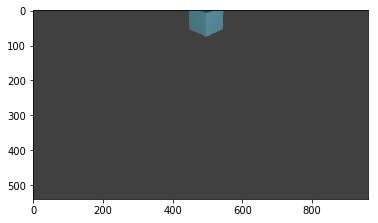

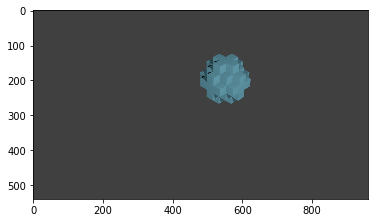

In [4]:
dataset = ToySpheres((6000, 1, 16, 16, 16), 1)

# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_loader)

for index in range(2):
    test_sphere = np.squeeze(dataset[index].detach().numpy())
    visualize3D(test_sphere, title="sample" + str(index), thresh=0.1)
    plt.show()


In [5]:
#Define AutoEncoder class

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 64, kernel_size = 5, stride = 1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # now 14x14x14
            nn.Conv3d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 12x12x12
            nn.MaxPool3d(2, stride=2),
            # 6x6x6
             nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 4x4x4
            nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 2x2x2
        )
        self.decoder = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 8, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Tanh(),
        )
        
    def forward(self, val):
        encoded = self.encoder(val)
        decoded = self.decoder(encoded)
        return encoded, decoded
        
    def encode(self, val):
        val = self.encoder(val)
        return val.cpu().data

    def decode(self, val):
        val = self.decoder(val)
        return val.cpu().data

In [6]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [7]:
sample_data = [dataset[0], dataset[1], dataset[2]]

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  0 | train loss: 0.0605


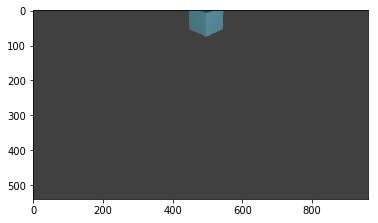

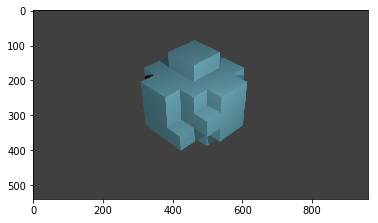

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


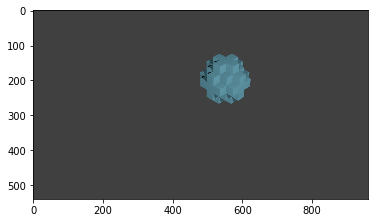

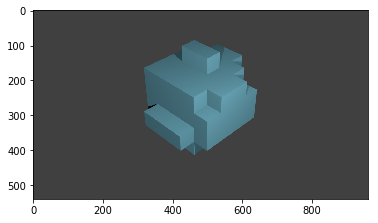

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


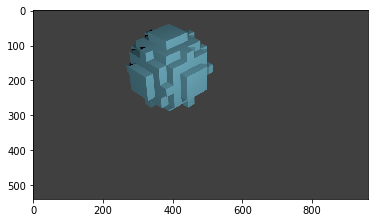

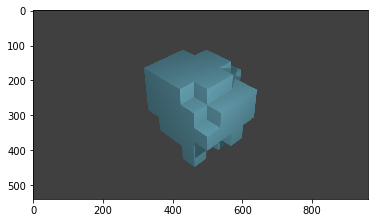

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  1 | train loss: 0.0394


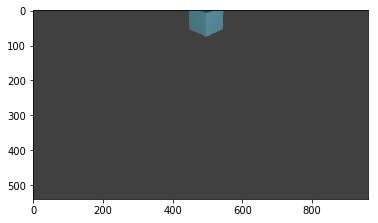

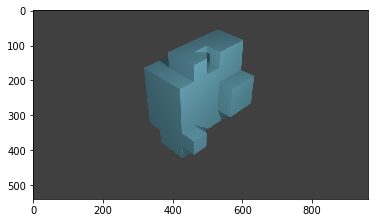

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


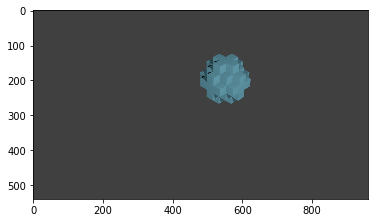

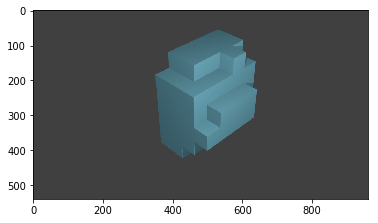

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


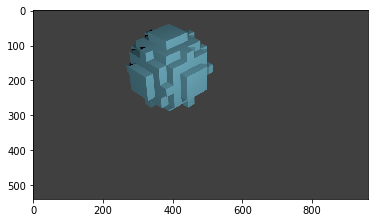

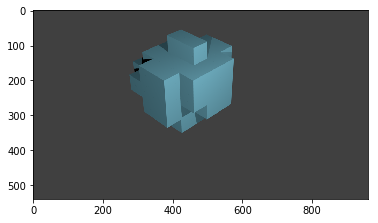

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  2 | train loss: 0.0294


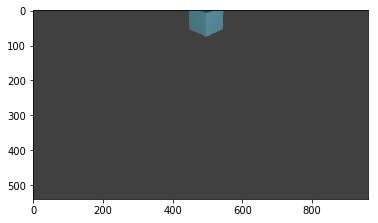

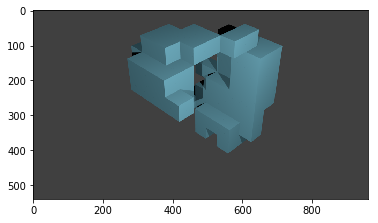

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


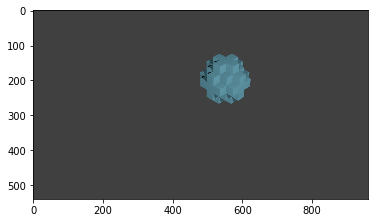

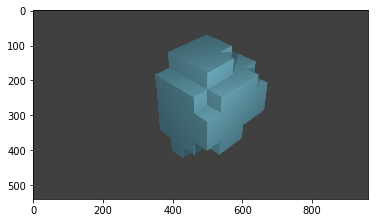

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


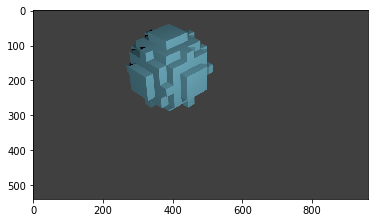

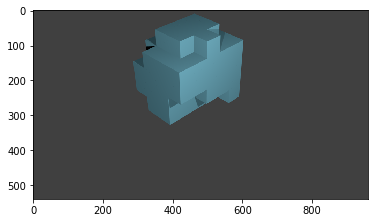

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  3 | train loss: 0.0336


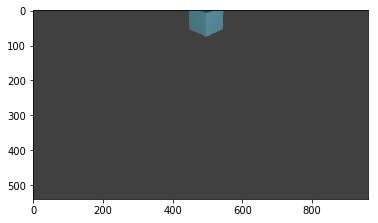

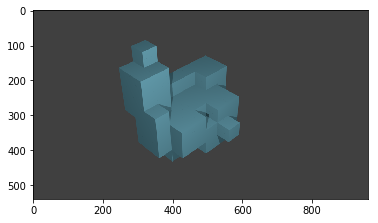

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


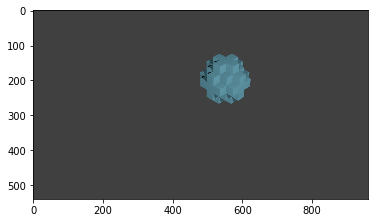

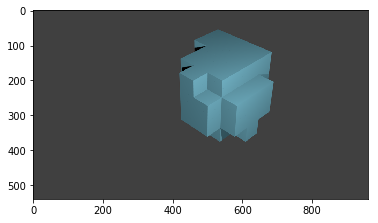

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


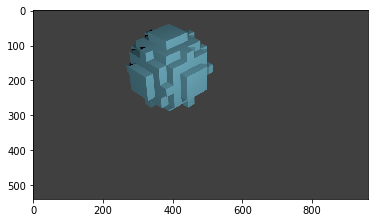

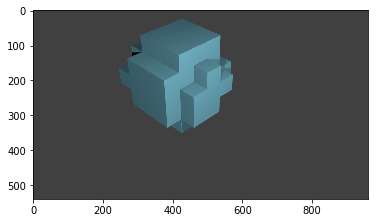

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  4 | train loss: 0.0345


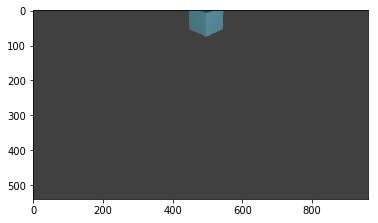

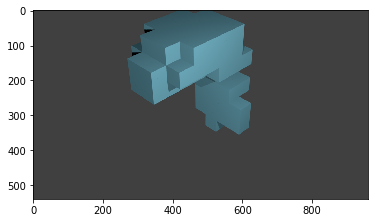

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


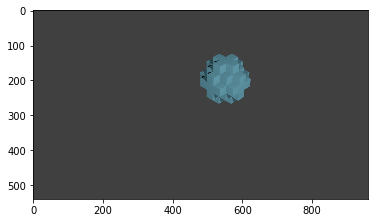

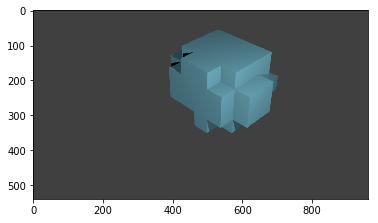

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


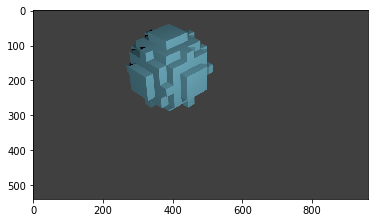

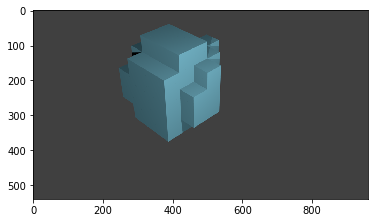

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
for epoch in range(EPOCH):
    for step, (x) in enumerate(train_loader):
        
        # batch x, shape (batch, 28, 28)
        b_x = x + NOISE_VAL * torch.rand_like(x) / (1.0 + NOISE_VAL) # Renormalize with added noise
        encoded, decoded = autoencoder(b_x)
        
        
        loss = loss_func(decoded, x)        # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())
            for n in range(3):
                test_data = sample_data[n].unsqueeze(0)
                _, decoded = autoencoder(test_data)
                true_sphere = np.squeeze(test_data.numpy())
                visualize3D(true_sphere, title="true_e" + str(epoch) + "_s" + str(step), percentile=0.85)
                plt.show()
                visualize3D(np.squeeze(decoded.detach().numpy()), title="decoded_e" + str(epoch) + "_s" + str(step), percentile=0.85)
                plt.show()